<a href="https://colab.research.google.com/github/hwayoung306/AI/blob/main/Pytorch%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%88%98%ED%99%94_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 환경 설정 및 데이터 로드

In [ ]:
import os
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [ ]:
#하이퍼 파라미터 튜닝

CFG = {
    'IMG_SIZE':32, #이미지 사이즈
    'EPOCHS':50, #에포크 : 학습 횟수
    'LEARNING_RATE':1e-3, #학습률
    'BATCH_SIZE':12, #배치사이즈 : 몇 개의 샘플로 가중치를 갱신할 것인지 설정
    'SEED':41, #시드
}

In [ ]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # 하이퍼파라미터 5번 셀 정의 SEED = 41

## 데이터 불러오기

In [ ]:
import pandas as pd
label_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_data/train.csv')
label_df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [ ]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1707 non-null   object
 1   label      1707 non-null   object
dtypes: object(2)
memory usage: 26.8+ KB


## 데이터 전처리

In [ ]:
label_df['label'][label_df['label'] == '10-1'] = 10 ## label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0 ## Label : 10-2 -> 0
label_df['label'] = label_df['label'].astype(int) ## type을 object에서 int로 변경

In [ ]:
label_df.head()

,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [ ]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1707 non-null   object
 1   label      1707 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.8+ KB


## 새로운 데이터 list에 넣기

In [ ]:
# x = '/content/drive/MyDrive/Colab Notebooks/user_data/train/006.png'

In [ ]:
# # 이미지의 local adress가 어떻게 분류되는지 확인
# print( x.split('/')[-1] ) # 파일 명만 가져오기
# print( x.split('/')[-1].split('.')[0] ) # 파일 명에서 확장자 빼고 사진 이름(숫자)만 가져오기

In [ ]:
# label_df['label'] # 사진에 담긴 수화의 값

In [ ]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(label_df['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    
    return img_path_list

In [ ]:
# 학습 데이터 중 전체 이미지 데이터, 전체 답
all_img_path, all_label = get_train_data('/content/drive/MyDrive/Colab Notebooks/user_data/train')

In [ ]:
# 테스트 데이터 중 전체 이미지 데이터(답이 없음)
test_img_path  = get_test_data('/content/drive/MyDrive/Colab Notebooks/user_data/test') 

In [ ]:
print( all_img_path[0:2] )      ; print() # 이미지 경로를 이미지 번호에 따라 오름차순 
print( all_label[0:5] )         ; print() # 이미지에 따른 라벨
print( test_img_path[0:2] )     ; print()  # 테스트 이미지 경로

['/content/drive/MyDrive/Colab Notebooks/user_data/train/001.png', '/content/drive/MyDrive/Colab Notebooks/user_data/train/002.png']

[0, 10, 3, 8, 9]

['/content/drive/MyDrive/Colab Notebooks/user_data/test/001.png', '/content/drive/MyDrive/Colab Notebooks/user_data/test/002.png']



## CustomDataset

전체 dataset을 구성하는 단계입니다.  

In [ ]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None: # 변환하는 법을 지정했다면~!
            image = self.transforms(image)

        if self.train_mode: # train_mode가 true라면 -> 학습 데이터라면?
            label = self.label_list[index]
            return image, label # index번째 사진과 label을 return
        else:
            return image        # 아니면 image만 리턴
    
    def __len__(self): #길이 return
        return len(self.img_path_list) # 이미지가 몇개 있는지 return하는 듯

#### Train / Validation Split

그럼 학습시킬 데이터 셋과 검증할 데이터 셋을 분리해주도록 하겠습니다.

In [ ]:
before_path = all_img_path[:1657]
before_label = all_label[:1657]

after_path = all_img_path[1657:]
after_label =  all_label[1657:]

In [ ]:
len(all_img_path) , len(before_path), len(after_path)

(1707, 1657, 50)

In [ ]:
before_len = int(len(before_path)*0.75)
after_len = int(len(after_path)*0.75)

In [ ]:
before_len, after_len

(1242, 37)

In [ ]:
train_img_path = before_path[:before_len] + after_path[:after_len]
train_label = before_label[:before_len] + before_label[:after_len]

vali_img_path = before_path[before_len:] + after_path[after_len:]
vali_label = before_label[before_len:] + before_label[after_len:] # 검증 답

In [ ]:
print( '데이터 총 길이 : ', len(all_img_path) )
print( 'train set 길이 : ', len(train_img_path) )
print( 'vaildation set 길이 : ', len(vali_img_path) )
print( '학습 + 확인 : ',  len(train_img_path) + len(vali_img_path) )

데이터 총 길이 :  1707
train set 길이 :  1279
vaildation set 길이 :  428
학습 + 확인 :  1707


In [ ]:
# 이렇게 변형 하겠다고 정의 함
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

## Dataloader
Dataloader class는 batch(한번에 처리하는 샘플 사이즈)기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 합니다. 

dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 됩니다. 

만들었던 dataset을 input으로 넣어주면 여러 옵션(데이터 묶기, 섞기, 알아서 병렬처리)을 통해 batch를 만들어 내는 것입니다.

* Train data를 DataLoader에 적용해 batch만들기

In [ ]:
# Get Dataloader
#CustomDataset class[ 25번째 셀 ] 를 통하여 train dataset생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)

* Vaildation을 DataLoader에 적용해 batch만들기

In [ ]:
# vaildation 에서도 적용
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)

In [ ]:
for i in range(5): ## 데이터 수 10배 증가 (100배로 증가시키고나서 진행해봤지만 성능은 더 안좋아졌습니다. 0.78정도)
    train_dataset+= CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
    vali_dataset += CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)

In [ ]:
# 만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) #BATCH_SIZE : 12
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :', len(train_img_path),'/ total train batches :', train_batches)
print('total valid imgs :', len(vali_img_path), '/ total valid batches :', vali_batches)

total train imgs : 1279 / total train batches : 640
total valid imgs : 428 / total valid batches : 214


## 이미지 및 shape 확인

Dataloader를 통해서 이미지가 잘 넣어졌는지 확인해보도록 해보겠습니다.    


In [ ]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) # iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
# 특성          라벨=정답                               # next는 이터레이터에서 값을 차례대로 꺼냅니다. 
# 12개로 묶어서 12개씩 들어있음

In [ ]:
train_labels

tensor([ 8,  7,  2,  2,  8,  4, 10,  1,  3,  1, 10,  5])

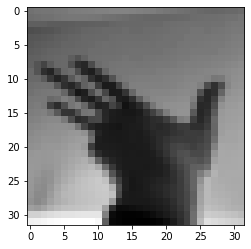

Label: 8


In [ ]:
img = train_features[0] # 
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

이미지와 라벨이 정상적으로 출력된 것을 확인했습니다.

그럼 torch의 shape가 옳바르게 입력이 되었는지 확인해보도록 하겠습니다.

In [ ]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Batch Labels shape: {train_labels}")

Feature batch shape: torch.Size([12, 3, 32, 32])
Batch Labels shape: tensor([ 8,  7,  2,  2,  8,  4, 10,  1,  3,  1, 10,  5])


torch.Size([12, 3, 128, 128])는 (batch_size, channels, high, width)를 의미합니다.   
Label의 shape를 보면 정상적으로 배치사이즈(12)만큼 나오는 것을 확인할 수 있습니다.

## 모델 구조 정의

이제 CNN 모델을 학습시키기 위한 데이터가 준비되었다면   
모델 구조를 설정하는 단계로 넘어가겠습니다.

In [ ]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함됨
#import torch.nn.init as init # 텐서에 초기값을 줌

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.keep_prob = 0.5 ## dropout에서 쓰임
        self.layer1 = torch.nn.Sequential(
            ##채널=1
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)) ## 절반으로 줄어듬
        
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 363, bias=True)
        # torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(), ##ReLU Sigmoid
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        self.fc2 = torch.nn.Linear(363, 11, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

## 모델 학습

이제 모델 학습을 하기 위해 매개변수를 정의해보도록 하겠습니다.

In [ ]:
import torch.optim as optim # 최적화 알고리즘들이 포함힘

model = CNNclassification().to(device)  # device = gpu
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"]) # LEARNING_RATE : 2e-2 = 학습률
scheduler = None

In [ ]:
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    #Loss Function 정의
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
            
        for img, label in iter(train_loader): # tqdm
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in iter(vali_loader): # tqdm
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset))) 
        
        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            # print('Model Saved.')

In [67]:
print('vail set: 손실 : 손실 / 배치 사이즈, accuracy : 맞은예측합계 / 데이터의 전체길이 (예측률%)')

vail set: 손실 : 손실 / 배치 사이즈, accuracy : 맞은예측합계 / 데이터의 전체길이 (예측률%)


In [ ]:
train(model, optimizer, train_loader, scheduler, device)

[1] Train loss: 1.2806649042
Vail set: Loss: 1.3627, Accuracy: 1524/2568 ( 59%)

[2] Train loss: 0.9555801152
Vail set: Loss: 1.2164, Accuracy: 1524/2568 ( 59%)

[3] Train loss: 0.7286733186
Vail set: Loss: 1.0981, Accuracy: 1734/2568 ( 68%)

[4] Train loss: 0.5663212875
Vail set: Loss: 1.1853, Accuracy: 1728/2568 ( 67%)

[5] Train loss: 0.4556273000
Vail set: Loss: 0.9432, Accuracy: 1980/2568 ( 77%)

[6] Train loss: 0.3904794297
Vail set: Loss: 1.2176, Accuracy: 1752/2568 ( 68%)

[7] Train loss: 0.3203723254
Vail set: Loss: 1.1441, Accuracy: 1944/2568 ( 76%)

[8] Train loss: 0.2671954488
Vail set: Loss: 1.1490, Accuracy: 1986/2568 ( 77%)

[9] Train loss: 0.2499059309
Vail set: Loss: 1.4188, Accuracy: 1902/2568 ( 74%)

[10] Train loss: 0.2214160930
Vail set: Loss: 1.3568, Accuracy: 1944/2568 ( 76%)

[11] Train loss: 0.1996104461
Vail set: Loss: 1.2105, Accuracy: 1932/2568 ( 75%)

[12] Train loss: 0.1864487728
Vail set: Loss: 1.4806, Accuracy: 1902/2568 ( 74%)

[13] Train loss: 0.204022

에포크가 36일때 Vaildation Accuracy가 64%로 best_model에 선정되어 저장되었습니다.

## 추론하기

이제 학습된 best_model을 가지고 test 셋의 라벨을 추론해보도록 하겠습니다.

In [68]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in iter(test_loader):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [69]:
import cv2
test_dataset = CustomDataset(test_img_path, None ,train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

[1, 2, 1, 6, 8]

값이 배열안에 정상적으로 잘 들어간 것을 확인할 수 있습니다.

## 제출하기

submission에 예측한 값 preds를 넣어줍시다

In [70]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_data/sample_submission.csv')
submission['label'] = preds

이제 제출을 위해 라벨을 다시 복원 시켜 줍니다.

앞서 10-1을 10으로, 10-2를 0으로 바꿔주었던 값을 다시 원래의 값으로 바꿔주겠습니다.

또한 label 열의 타입을 int에서 object로 수정해 주겠습니다.

In [71]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
submission.head(10)

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8
5,006.png,10-1
6,007.png,10-1
7,008.png,2
8,009.png,4
9,010.png,4


submission을 csv 파일로 저장합니다.   

index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다.   

정확한 채점을 위해 꼭 index=False를 넣어주세요.

In [73]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submit.csv', index=False)

이렇게 생성된 submission.csv 파일을 데이콘 대회 페이지에 업로드 & 제출하여 결과를 확인해보세요!

문제를 해결하기 위한 여러분의 방법을 코드 공유 게시판에 공유해주세요

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!